# Anomaly Detection on Yeast Dataset - LE Linh Long

Dataset: https://archive.ics.uci.edu/ml/datasets/Yeast


# 1. Import Libraries & Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest            
from sklearn.neighbors import LocalOutlierFactor        
from sklearn.svm import OneClassSVM                   
from scipy import stats 
from scipy.spatial.distance import mahalanobis 
from scipy.stats import chi2 
from pandas.plotting import parallel_coordinates  
from matplotlib.lines import Line2D
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist
from pyod.models.gmm import GMM
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS, Isomap
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('yeast.csv')
df.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,name
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


# 2. Exploratory Data Analysis

First of all, I will check all the column, as well as their type. I also check if there's any missing values or not, so I can see if I must use imputation or not

In [3]:
print("Data Info:")
print(df.info())

Data Info:
<class 'pandas.DataFrame'>
RangeIndex: 1484 entries, 0 to 1483
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     1484 non-null   float64
 1   gvh     1484 non-null   float64
 2   alm     1484 non-null   float64
 3   mit     1484 non-null   float64
 4   erl     1484 non-null   float64
 5   pox     1484 non-null   float64
 6   vac     1484 non-null   float64
 7   nuc     1484 non-null   float64
 8   name    1484 non-null   str    
dtypes: float64(8), str(1)
memory usage: 104.5 KB
None


Summarize the dataset for all numerical values:

In [4]:
print("Summary statistics:")
print(df.describe())

Summary statistics:
               mcg          gvh          alm          mit          erl  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean      0.500121     0.499933     0.500034     0.261186     0.504717   
std       0.137299     0.123924     0.086670     0.137098     0.048351   
min       0.110000     0.130000     0.210000     0.000000     0.500000   
25%       0.410000     0.420000     0.460000     0.170000     0.500000   
50%       0.490000     0.490000     0.510000     0.220000     0.500000   
75%       0.580000     0.570000     0.550000     0.320000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               pox          vac          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.007500     0.499885     0.276199  
std       0.075683     0.057797     0.106491  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.480000     0.220000  
50%       0.000000     0.510000

Drop the label column for further analysis

In [5]:
df_main = df.drop(columns=['name'])
df_main.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22


Visualization to understand more about the distribution of the dataset

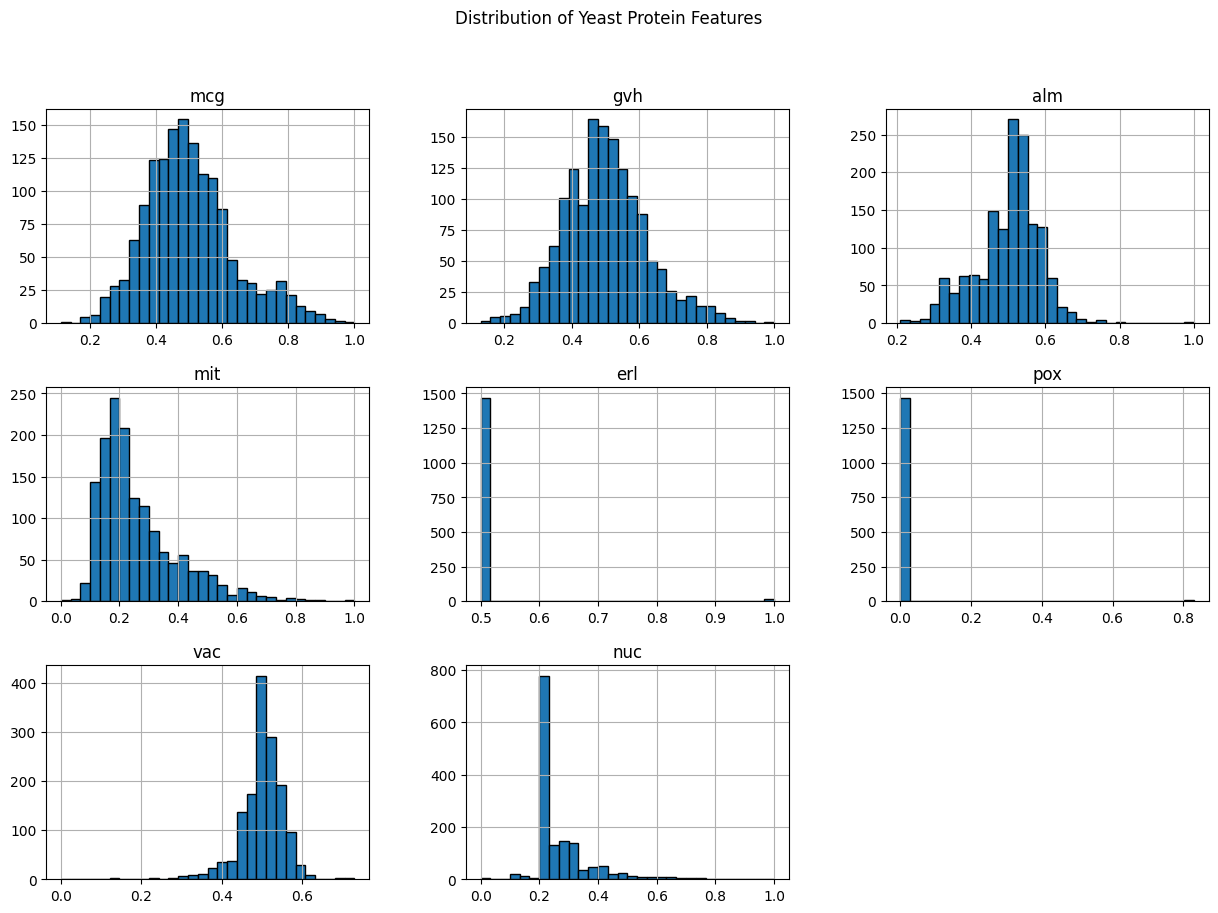

In [6]:
df_main.hist(bins=30, figsize=(15, 10), layout=(3, 3), edgecolor='black')
plt.suptitle('Distribution of Yeast Protein Features')
plt.show()

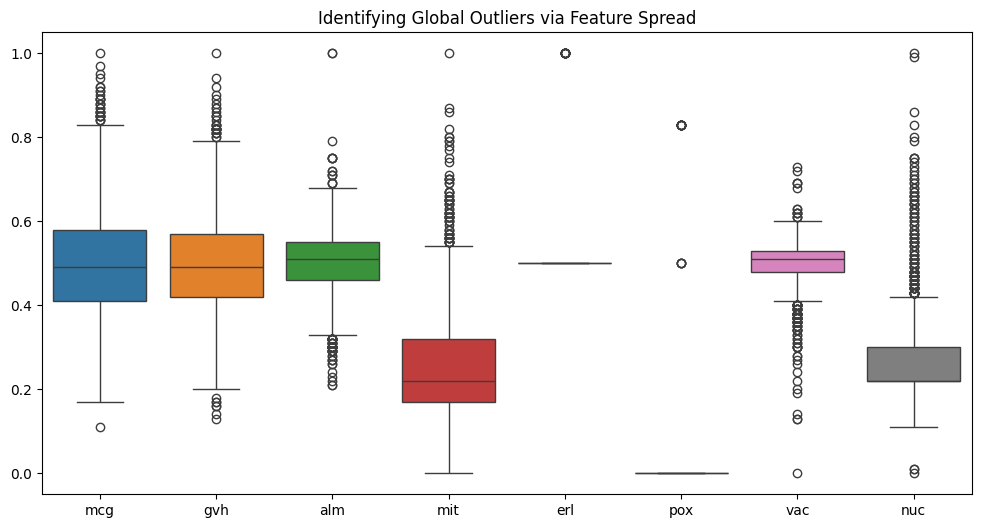

In [7]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_main)
plt.title('Identifying Global Outliers via Feature Spread')
plt.show()

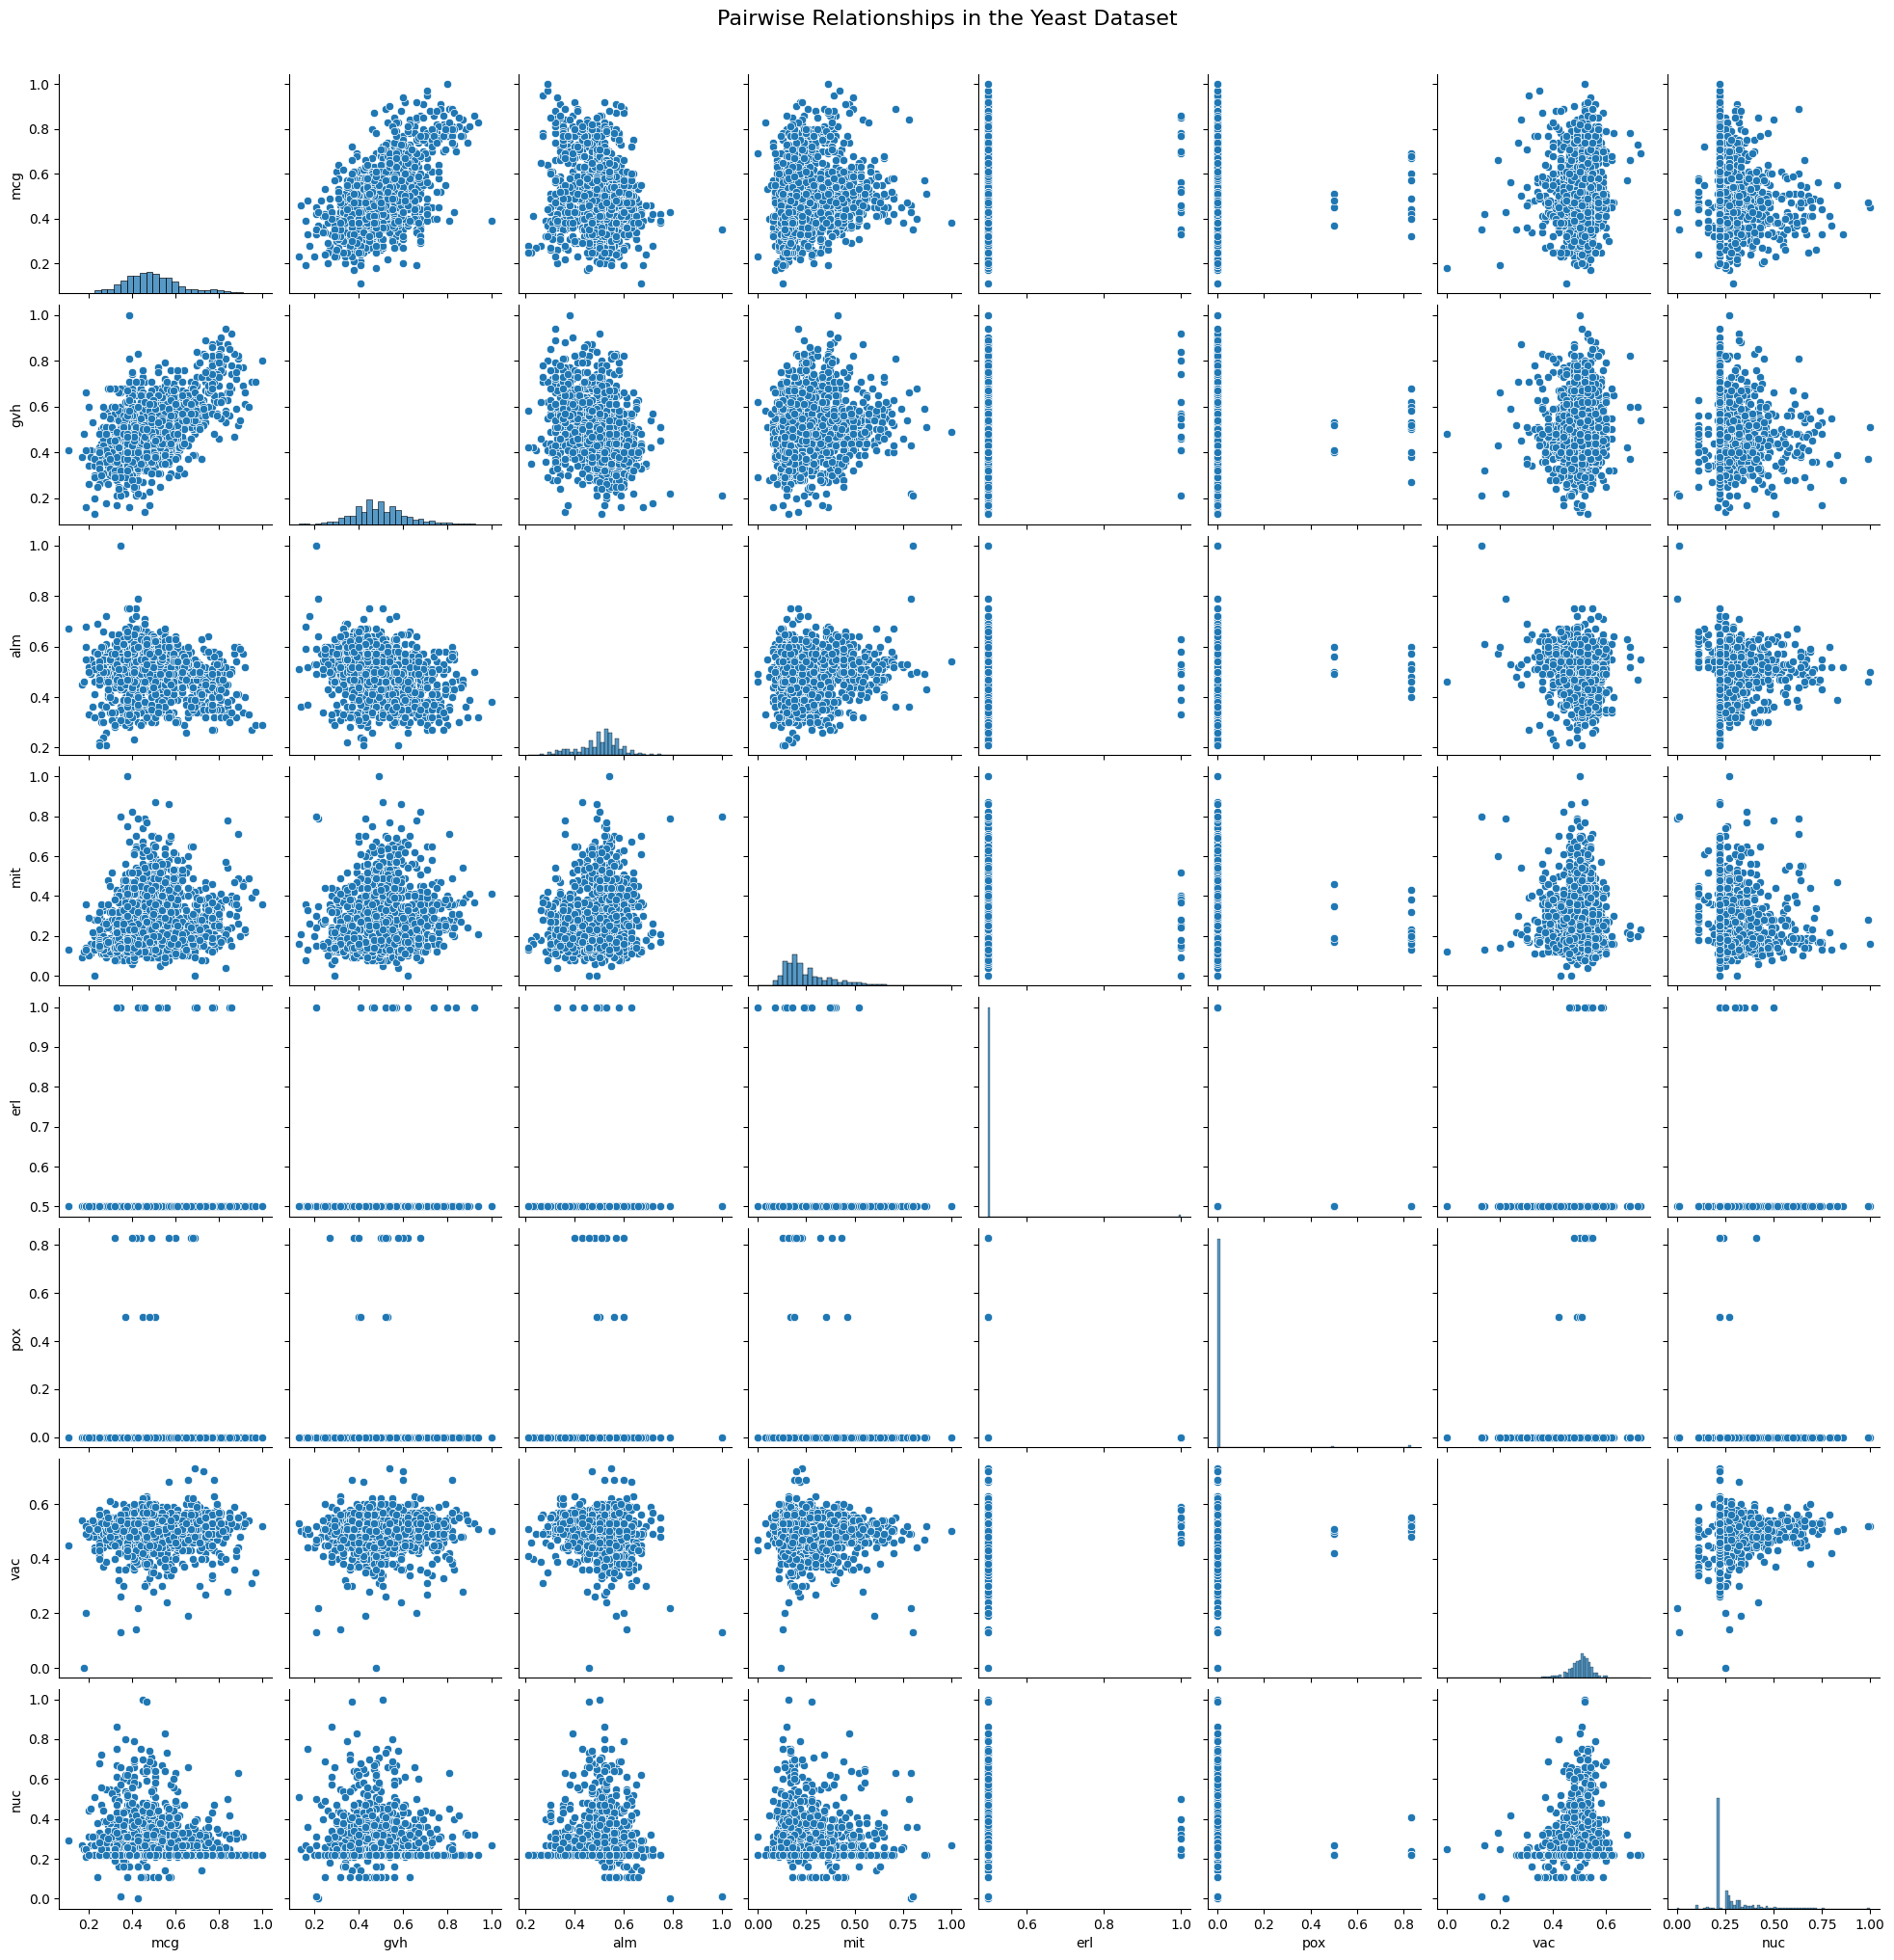

In [8]:
sns.pairplot(df_main)
plt.suptitle("Pairwise Relationships in the Yeast Dataset", y=1.02, fontsize=16)
plt.show()

As seen from those graphs, features mcg, gvh, alm show a stable bell-shaped distributions, meanwhile features mit, nuc, vac are highly skewed. Features erl and pox are almost completely dominated by a single value 0.5 and 0. Besides, the relationships between these features are non-linear because the scatter plots mostly look like circular clouds or messy blobs rather than a straight lines. This shows that the scatter plots reveal a lack of significant linear correlation, appearing as random clouds.

# 3. Correlation Matrices

Although all the features are uncorrelated, I will apply correlation matrices to check linear dependancy of features. Although Pearson is not the most suitable measure for this dataset because it cannot capture non-linear relationships, I will still include it for experiment.

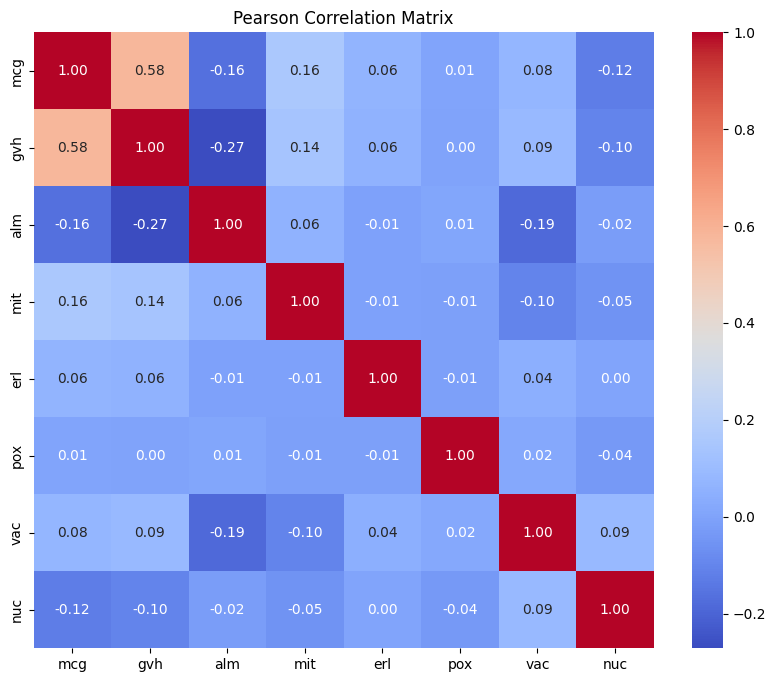

In [9]:
pearson_corr = df_main.corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Pearson Correlation Matrix")
plt.show()

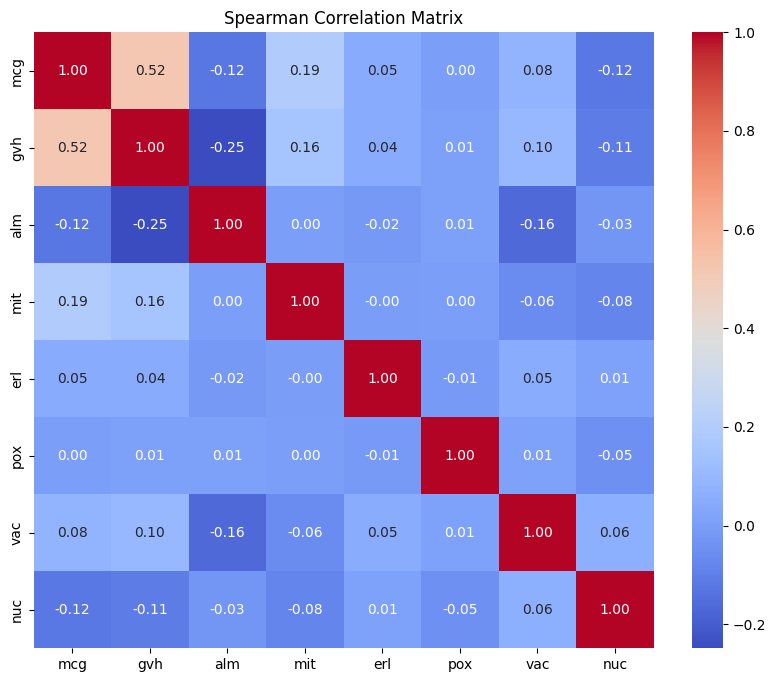

In [10]:
spearman_corr = df_main.corr(method='spearman')
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Matrix")
plt.show()

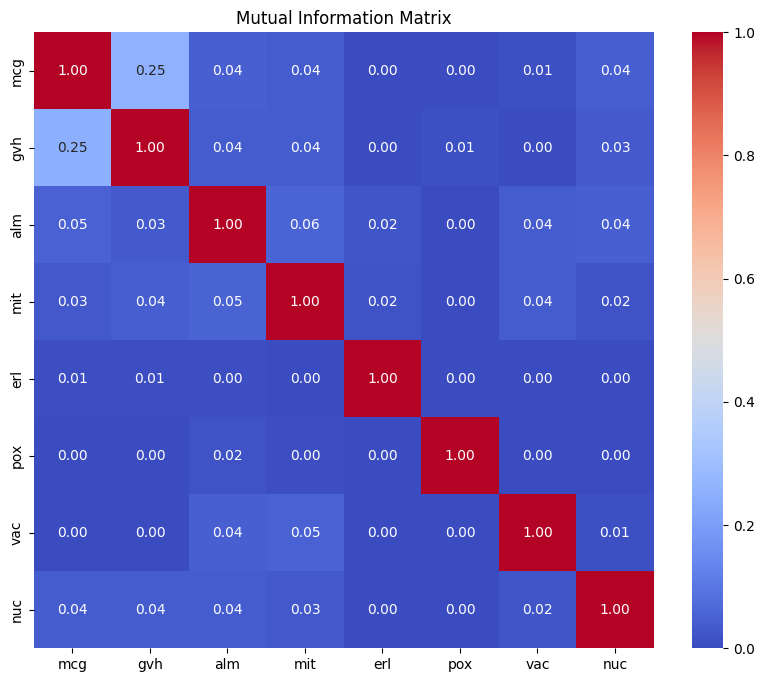

In [11]:
def mi_matrix(df):
    cols = df.columns
    n = len(cols)
    matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                matrix.iloc[i, j] = 1.0 
            else:
                mi = mutual_info_regression(df[[cols[i]]], df.iloc[:, j], random_state=42)
                matrix.iloc[i, j] = mi[0]
    return matrix

mi_df = mi_matrix(df_main)
plt.figure(figsize=(10, 8))
sns.heatmap(mi_df, annot=True, cmap='coolwarm',fmt=".2f")
plt.title("Mutual Information Matrix")
plt.show()

As observed from the matrices above, there is almost no linear dependency across the dataset, with most of feature pairs showing a near zero correlation values. The only exception is a moderate relationship between mcg and gvh, but even this does not translate into broader statistical redundancy across the other variables.

# 4. Data Preprocessing


In this section, I will do 2 main tasks:
* Data Scaling
* Dimensionality Reduction

First of all, I will scale the data using RobustScaler. Since  my data has extreme outliers, as notably seen in erl, pox, mit, and nuc, and my data is heavily skewed, RobustScaler is the right tool for the job because it's much less sensitive to extreme values than other common scalers by using the median and the Interquartile Range to scale the data. Unlike StandardScaler, which gets pulled off-track by the mean and variance of outliers, or MinMaxScaler, which squashes all normal data into a tiny range to fit extreme values. This keeps the main cluster of data well spaced and easy to analyze. At the same time, it allows the anomalies to remain distinct and far away from the rest of the group, which is exactly what I need for anomaly detection.

For dimensionality reduction, this dataset is relatively small and narrow with 1484 rows and 8 columns, for that reason, dimensionality reduction is not necessary and will not be applied for further analysis. Besides that, I also prefer efficiency more, so I do not apply dimensionality reduction in order to ensure that all of the data information is preserved and no useful information is lost. 

Nevertheless, I will still apply 4 different dimensionality reduction techniques for experiment, to see how they behave on this dataset and check whether any of them bring meaningful advantages:

- PCA
- LLE
- MDS
- Isomap

Although t-SNE and UMAP are also dimensionality reduction methods, they are mainly designed for visualization. Therefore, I will not use them from this evaluation, and I will just use t-SNE for visualization purpose after detecting anomalies because it works great on high dimensional data. Besides, UMAP is highly sensitive to hyperparameter choices, and extensive parameter tuning can be very exhausting.

## Data Scaling

In [12]:
scaler = RobustScaler()
df_scaled = scaler.fit_transform(df_main)
df_scaled = pd.DataFrame(df_scaled, columns=df_main.columns)
df_scaled.head()    

,mcg,gvh,alm,mit,erl,pox,vac,nuc
0,0.529412,0.800000,-0.444444,-0.600000,0.0,0.0,-0.6,0.0
1,-0.352941,1.200000,-0.333333,0.333333,0.0,0.0,0.4,0.0
2,0.882353,0.866667,-0.222222,-0.466667,0.0,0.0,0.4,0.0
3,0.529412,-0.333333,0.666667,-0.600000,0.0,0.0,0.6,0.0
4,-0.411765,-0.333333,-0.333333,2.133333,0.0,0.0,-0.6,0.0


## PCA

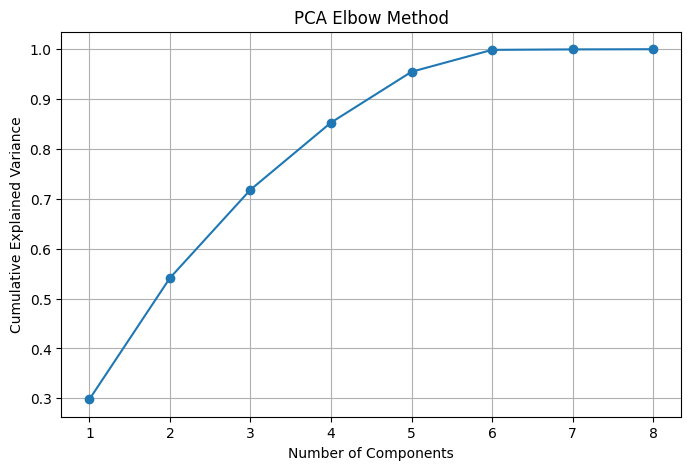

In [ ]:
explained_variance = []
dimensions = range(1, 9) 
# Although it should be from range 1 to 8 because my dataset has 8 features only, 
# I still want to set to range 9 because I want to do experiment about non-linear dimensionality reduction, how many will they return.

for i in dimensions:
    pca = PCA(n_components=i)
    pca.fit_transform(df_scaled) 
    explained_variance.append(pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8,5))
plt.plot(range(1,9), explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Elbow Method')
plt.grid(True)
plt.show()

In [14]:
explained_variance

[np.float64(0.29823210795076166),
 np.float64(0.5414440162110528),
 np.float64(0.7183565081484679),
 np.float64(0.8529313459837491),
 np.float64(0.9547646403432314),
 np.float64(0.9987065572033267),
 np.float64(0.9996264631973752),
 np.float64(1.0)]

As observed from the graph, the cumulative explained variance shows a strong increase through the first four components. Starting at the 5th component, the marginal gain in information begins to reduce. Furthermore, the cumulative explained variance requires 5 components to reach the 95% threshold, while 6 components are needed to reach the 99% threshold to fully represent the whole dataset. For those reasons, PCA is a good method for this dataset.

## LLE

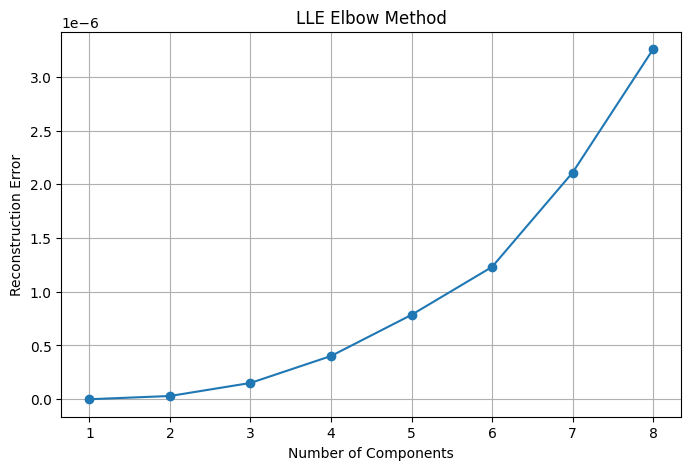

In [15]:
errors = []

for i in dimensions:
    lle = LocallyLinearEmbedding(n_neighbors=10, n_components=i) # followed by a tutorial on geeksforgeeks, I set the number of neighbors to 10
    lle.fit(df_scaled)
    errors.append(lle.reconstruction_error_)

plt.figure(figsize=(8, 5))
plt.plot(dimensions, errors, marker='o')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('LLE Elbow Method')
plt.show()

In [16]:
errors

[np.float64(5.5334070653786515e-15),
 np.float64(3.0004016812617853e-08),
 np.float64(1.5142290582995803e-07),
 np.float64(4.0207804776201495e-07),
 np.float64(7.851573088322757e-07),
 np.float64(1.2308122102749193e-06),
 np.float64(2.1081743208390264e-06),
 np.float64(3.256223766764997e-06)]

As shown from the graph, the reconstruction errors remain near zero for all 8 components. Especially from 1–3 components, the errors are extremely small, indicating that the dataset shows strong local linear structure. However, near-zero reconstruction error does not guarantee that global structure is fully preserved or that no information is lost. Since the error is very small, it is a sign for something's wrong. Let's set components = 2 and visualize it.

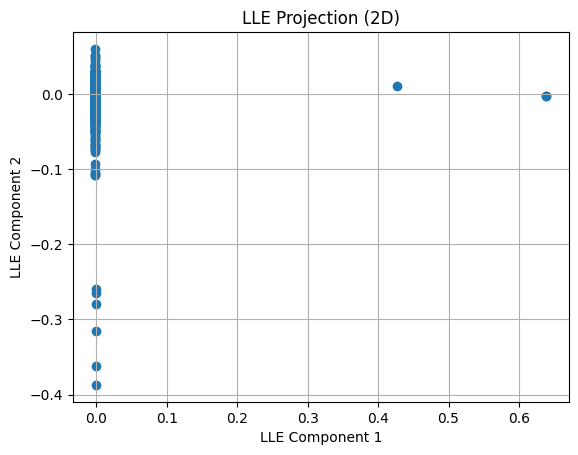

In [17]:
lle = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
df_lle = lle.fit_transform(df_scaled)

plt.figure()
plt.scatter(df_lle[:, 0], df_lle[:, 1])
plt.xlabel("LLE Component 1")
plt.ylabel("LLE Component 2")
plt.title("LLE Projection (2D)")
plt.grid(True)
plt.show()

As observed, LLE has collapsed. Instead of visualizing a 2D map, the algorithm squeezes almost all the points at single line at X ~= 0, with a couple of extreme outliers floating to the right. Therefore, my hypothesis about this method has a problem is correct, and LLE is not a good method for this technique.

## MDS

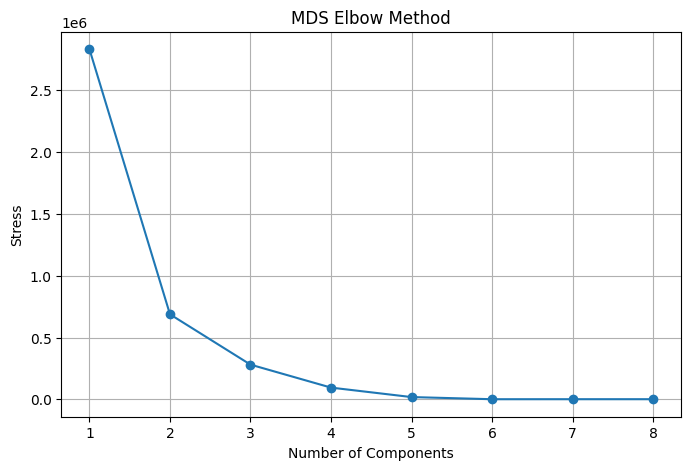

In [18]:
stress = []

for i in dimensions:
    mds = MDS(n_components=i)
    mds.fit(df_scaled)
    stress.append(mds.stress_)

plt.figure(figsize=(8, 5))
plt.plot(dimensions, stress, marker='o')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('MDS Elbow Method')
plt.show()

In [19]:
stress

[np.float64(2832920.6982632554),
 np.float64(687728.9043944101),
 np.float64(280520.21532576013),
 np.float64(94652.60735526023),
 np.float64(18044.15298693414),
 np.float64(653.7810505303287),
 np.float64(790.4667864031657),
 np.float64(840.4594253444889)]

As observed from the graph, the stress decreases significantly up to 6 components, and then it begins to rise at the 7th and 8th components. However, even when we keep 6 components, the stress is too high. This shows that this method cannot preserve the global distance relationships of this dataset in a lower-dimensional space.

## Isomap

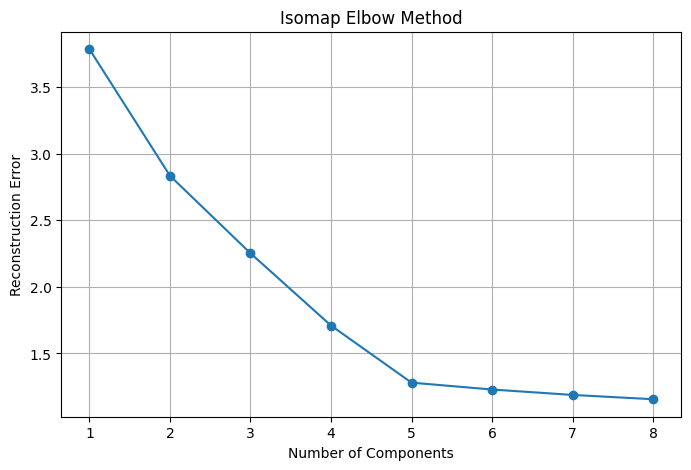

In [20]:
isomap_errors = []

for d in dimensions:
    iso = Isomap(n_neighbors=10, n_components=d)
    iso.fit(df_scaled)
    isomap_errors.append(iso.reconstruction_error())

plt.figure(figsize=(8, 5))
plt.plot(dimensions, isomap_errors, marker='o')
plt.grid(True)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Isomap Elbow Method')
plt.show()

In [21]:
isomap_errors

[np.float64(3.7828114163944444),
 np.float64(2.8331728641947933),
 np.float64(2.2515358035456905),
 np.float64(1.709080130527436),
 np.float64(1.2807005882820992),
 np.float64(1.2292268158127544),
 np.float64(1.1885149033131448),
 np.float64(1.156352065036789)]

Unlike LLE, the reconstruion error shows a declining trends as the number of components increases. The most significant reduction are in between 1-5 components, after which the improvement becomes smaller. However, the reconstruction error remains relatively high even at 8 components, suggesting that Isomap may not be the most suitable technique for this dataset.

# 5. Anomaly Detection Methods

Since this data is multivariate, I will not choose univariate technique like Z-score, IQR.... because they evaluate each feature independently and can't capture relationships between variables. 

For that reason, after searching the whole Internet, I will test out five multivariate models to compare their performance, and find out which one is the best for this dataset.

- Isolation Forest 

- Mahalanobis Distance 

- Local Outlier Factor 

- Gaussian Mixture 

- One-Class SVM

## Isolation Forest

In [22]:
df_if = df_scaled.copy()
iso_forest = IsolationForest(random_state=42) 
# I'm using all default parameters from scikit-learn IF because I want to keep it fair between methods

iso_forest.fit(df_if)
print("Isolation Forest Anomaly Counts:")
df_if['anomaly'] = iso_forest.predict(df_if)
print(df_if['anomaly'].value_counts())

Isolation Forest Anomaly Counts:
anomaly
 1    1385
-1      99
Name: count, dtype: int64


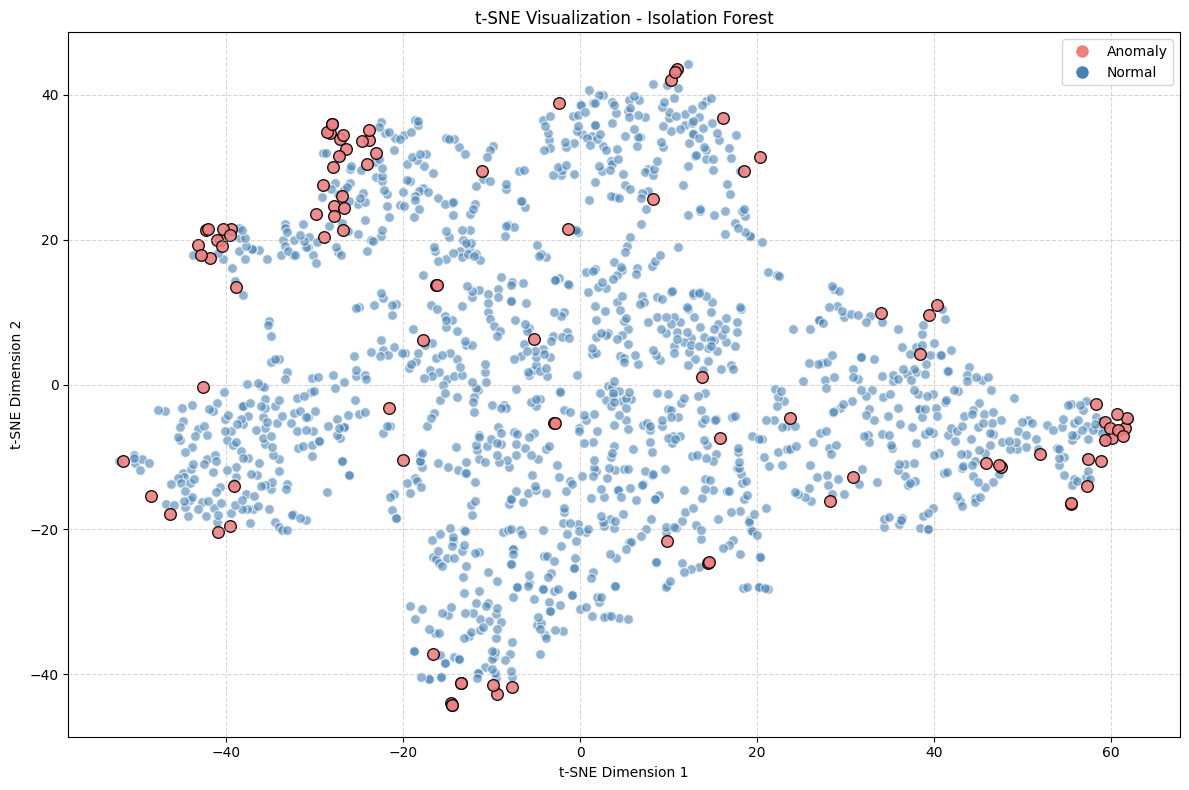

In [25]:
X = df_if.drop('anomaly', axis=1)
y = df_if['anomaly']
tsne = TSNE(n_components=2) 
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], c='steelblue', label='Normal', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_embedded[y == -1, 0], X_embedded[y == -1, 1], c='lightcoral', label='Anomaly', alpha=0.9, edgecolors='k', s=70)

plt.title('t-SNE Visualization - Isolation Forest')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10)]
plt.legend(custom_lines, ['Anomaly', 'Normal'], loc='best')

plt.tight_layout()
plt.show()

As observed from the graph, most of the anomaly detected are located at the very outer edges of the normal clusters or in empty spaces where there aren't many other values. However, there are a few anomalies scattered right in the middle of the normal cluster. This shows that some anomalies share strong similarity with normal data, making Isolation Forest difficult to seperate them.

## Mahalanobis Distance

In [26]:
df_md = df_scaled.copy()
mean_vec = df_md.mean().values
cov_matrix = np.cov(df_md.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

df_md['mahalanobis'] = df_md.apply(lambda row: mahalanobis(row.values, mean_vec, inv_cov_matrix), axis=1)
p_val = 0.975  
# => the rest 2.5% are counted as anomalies. I looked up on mahalanobis distance online and I saw people set to 97.5%
# After reading for a while, 97.5 is great because if we set to 95, more points flagged as anomalies, risk of false positives. 
# And if we set to 99, we will miss more true anomalies.

threshold = np.sqrt(chi2.ppf(p_val, df=df_md.shape[1]))
df_md['anomaly'] = np.where(df_md['mahalanobis'] > threshold, -1, 1)

print("Mahalanobis Distance Anomaly Counts:")
print(df_md['anomaly'].value_counts())

Mahalanobis Distance Anomaly Counts:
anomaly
 1    1415
-1      69
Name: count, dtype: int64


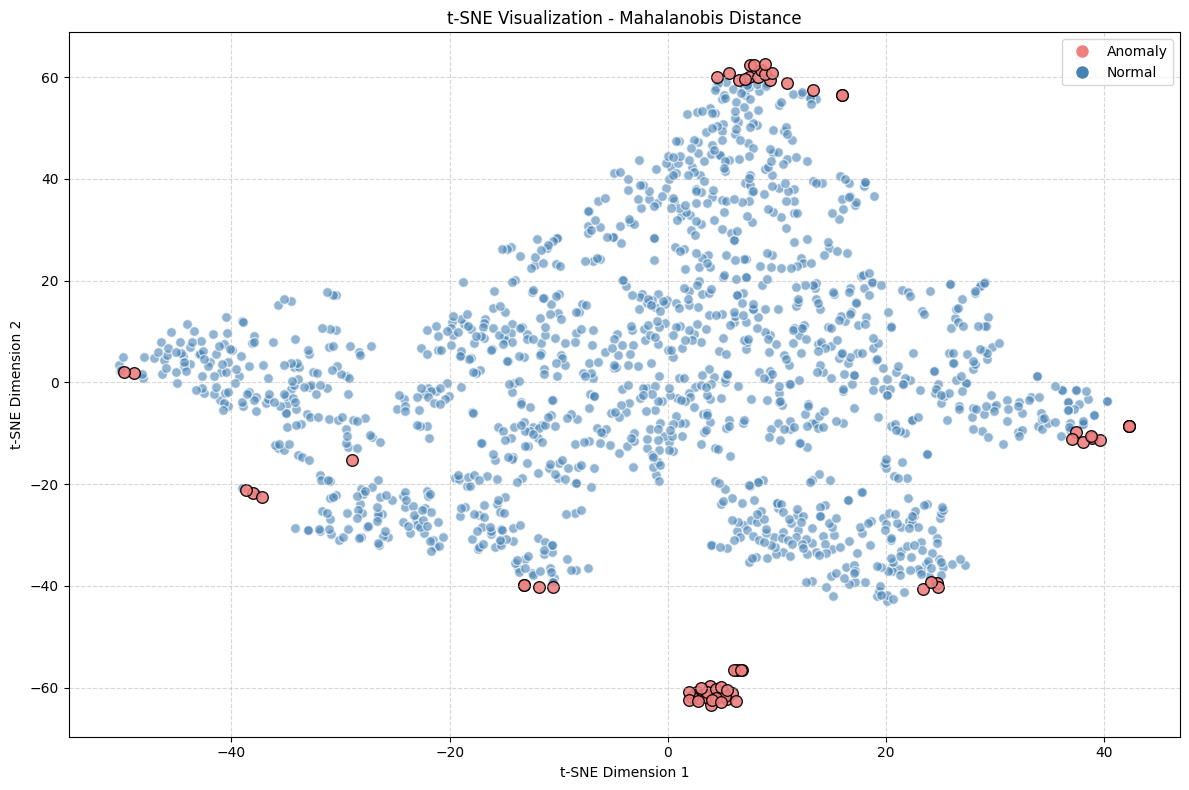

In [29]:
X = df_md.drop('anomaly', axis=1)
y = df_md['anomaly']
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], c='steelblue', label='Normal', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_embedded[y == -1, 0], X_embedded[y == -1, 1], c='lightcoral', label='Anomaly', alpha=0.9, edgecolors='k', s=70)

plt.title('t-SNE Visualization - Mahalanobis Distance')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10)]
plt.legend(custom_lines, ['Anomaly', 'Normal'], loc='best')

plt.tight_layout()
plt.show()

Similar to Isolation Forest, most of the anomaly detected are located at the very outer edges of the normal clusters. There is even distinct cluster of anomaly completely separated from the rest. However, unlike Isolation Forest, there are almost no anomaly point get mixed in the normal cluster, showing that Mahalanobisis very strict about what it considers anomaly. 

## Local Outlier Factor

In [30]:
df_lof = df_scaled.copy()
lof = LocalOutlierFactor()
df_lof['anomaly'] = lof.fit_predict(df_lof)
print("LOF Anomaly Counts:")
print(df_lof['anomaly'].value_counts())

LOF Anomaly Counts:
anomaly
 1    1429
-1      55
Name: count, dtype: int64


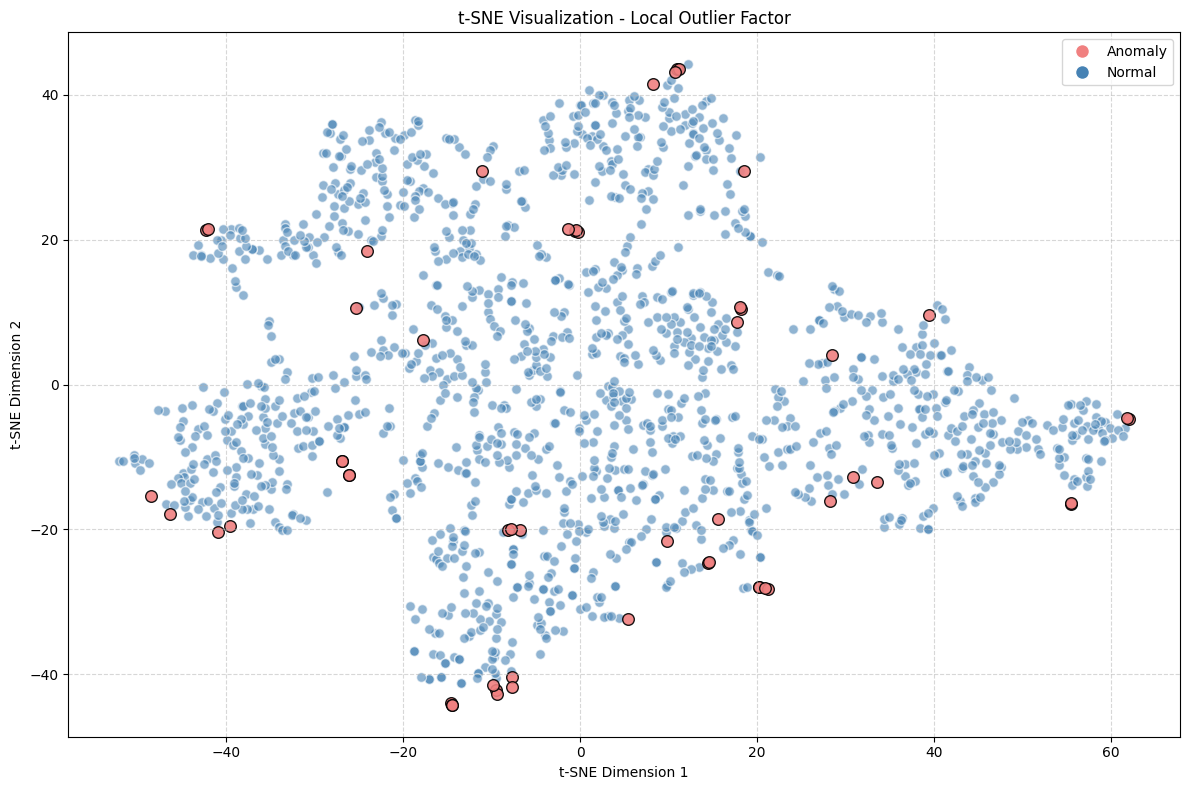

In [31]:
X = df_lof.drop('anomaly', axis=1)
y = df_lof['anomaly']
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], c='steelblue', label='Normal', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_embedded[y == -1, 0], X_embedded[y == -1, 1], c='lightcoral', label='Anomaly', alpha=0.9, edgecolors='k', s=70)

plt.title('t-SNE Visualization - Local Outlier Factor')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10)]
plt.legend(custom_lines, ['Anomaly', 'Normal'], loc='best')

plt.tight_layout()
plt.show()

Unlike other methods mentioned, Local Outlier Factor finds unusual points anywhere, makes the data starts to look less crowded compared to the groups nearby. While some anomaly points are actually quite close to the normal clusters, they are flagged because they are less crowded than the dense groups surrounding them.  This shows that LOF doesn't just look for points at the far edges of the map, but rather identifies points that are "lonelier" than their neighbors. 

## Gaussian Mixture 

In [32]:
df_gmm = df_scaled.copy()
gmm_detector = GMM()
gmm_detector.fit(df_gmm)
df_gmm['anomaly'] = gmm_detector.labels_
print("Gaussian Mixture Anomaly Counts:")
print(df_gmm['anomaly'].value_counts())

Gaussian Mixture Anomaly Counts:
anomaly
0    1335
1     149
Name: count, dtype: int64


In [33]:
df_gmm['anomaly'] = df_gmm['anomaly'].replace({0: 1, 1: -1}) # change the label to match other models
df_gmm.head()

,mcg,gvh,alm,mit,erl,pox,vac,nuc,anomaly
0,0.529412,0.800000,-0.444444,-0.600000,0.0,0.0,-0.6,0.0,1
1,-0.352941,1.200000,-0.333333,0.333333,0.0,0.0,0.4,0.0,1
2,0.882353,0.866667,-0.222222,-0.466667,0.0,0.0,0.4,0.0,1
3,0.529412,-0.333333,0.666667,-0.600000,0.0,0.0,0.6,0.0,1
4,-0.411765,-0.333333,-0.333333,2.133333,0.0,0.0,-0.6,0.0,1


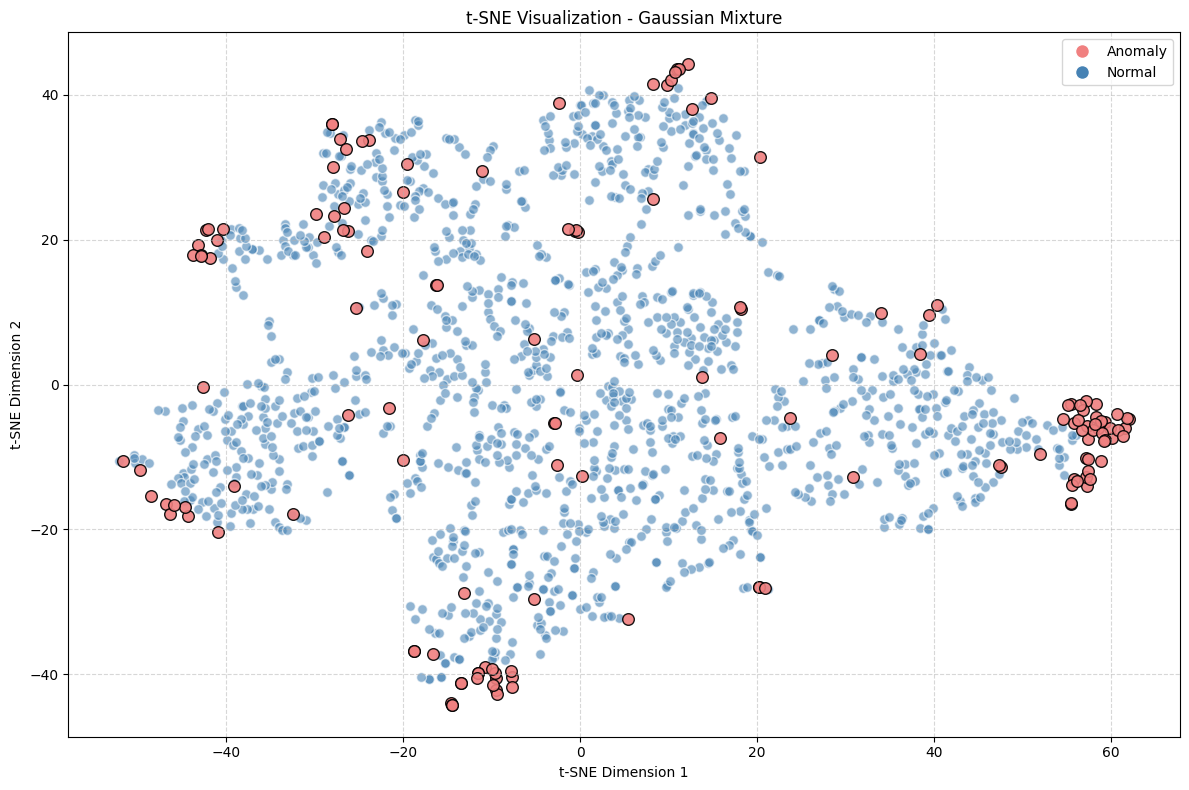

In [34]:
X = df_gmm.drop('anomaly', axis=1)
y = df_gmm['anomaly']
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], c='steelblue', label='Normal', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_embedded[y == -1, 0], X_embedded[y == -1, 1], c='lightcoral', label='Anomaly', alpha=0.9, edgecolors='k', s=70)

plt.title('t-SNE Visualization - Gaussian Mixture')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10)]
plt.legend(custom_lines, ['Anomaly', 'Normal'], loc='best')

plt.tight_layout()
plt.show()

As observed from the graph, while many anomalies are found at the outer edges, there is a dense distinct anomaly cluster on the far right. Similar to Isolation Forest, GMM also flags several points deep within the clusters, suggesting it is highly sensitive to the specific statistical shape of each group. This shows that GMM is effective at catching points that don't fit the expected distribution, even if they are physically surrounded by normal data.

## One-Class SVM

In [35]:
df_ocsvm = df_scaled.copy()
ocsvm = OneClassSVM()
df_ocsvm['anomaly'] = ocsvm.fit_predict(df_ocsvm)

print("One-Class SVM Anomaly Counts:")
print(df_ocsvm['anomaly'].value_counts())

One-Class SVM Anomaly Counts:
anomaly
-1    743
 1    741
Name: count, dtype: int64


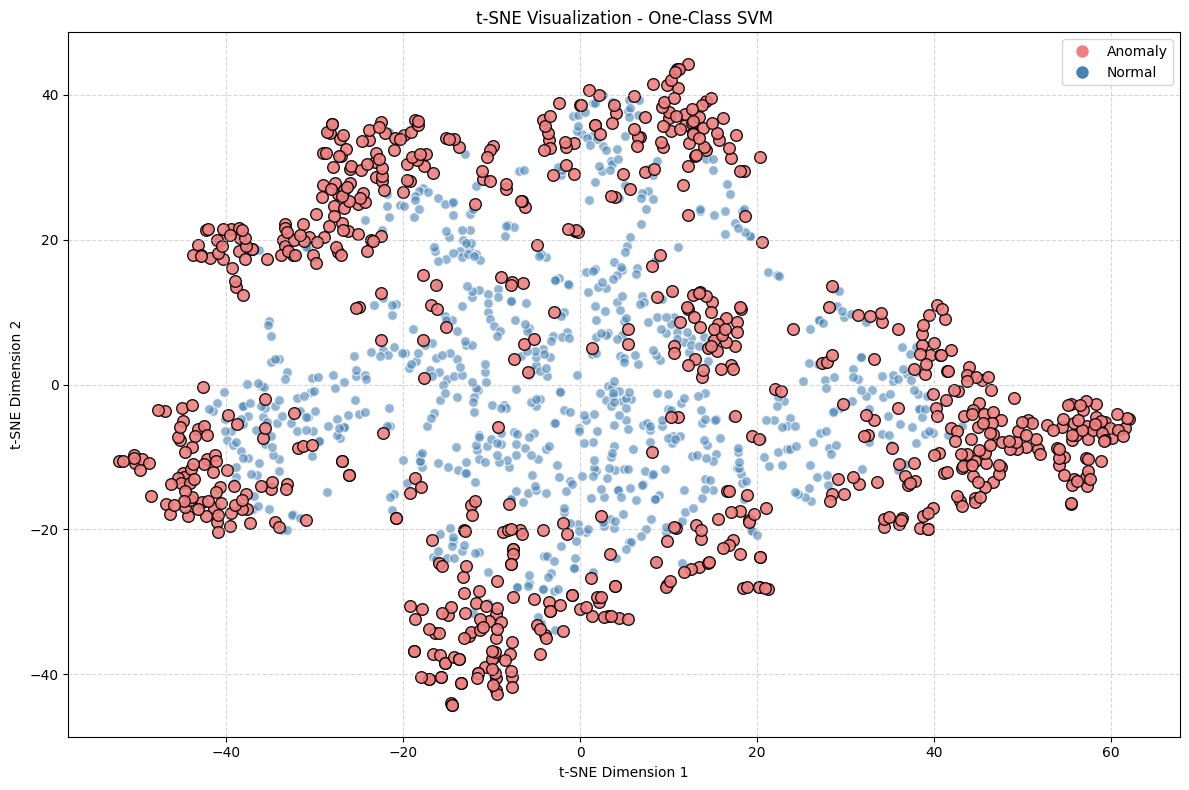

In [36]:
X = df_ocsvm.drop('anomaly', axis=1)
y = df_ocsvm['anomaly']
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

plt.figure(figsize=(12, 8))
plt.scatter(X_embedded[y == 1, 0], X_embedded[y == 1, 1], c='steelblue', label='Normal', alpha=0.6, edgecolors='w', s=50)
plt.scatter(X_embedded[y == -1, 0], X_embedded[y == -1, 1], c='lightcoral', label='Anomaly', alpha=0.9, edgecolors='k', s=70)

plt.title('t-SNE Visualization - One-Class SVM')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

custom_lines = [Line2D([0], [0], marker='o', color='w', markerfacecolor='lightcoral', markersize=10),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10)]
plt.legend(custom_lines, ['Anomaly', 'Normal'], loc='best')

plt.tight_layout()
plt.show()

Unlike the other methods mentioned, One-Class SVM flags half of the dataset is anomaly. Instead of finding isolated outliers, it carves out a very tight place for normal data, leaving a think shell of anomalies that completely surround the core clusters. This shows that the model is far too aggressive, essentially defining normal so strictly that anything outside the absolute highest-density centers is marked as anomaly.

# 6. Comparision Between All Models

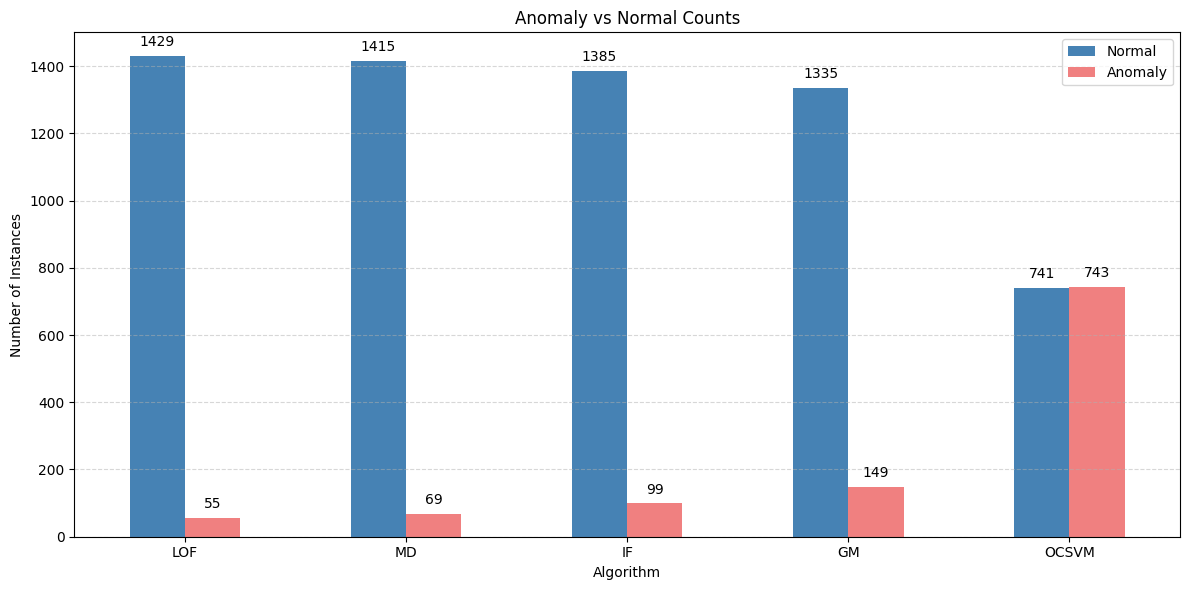

In [84]:
models = {
    'IF': df_if,
    'MD': df_md,
    'LOF': df_lof,
    'GM': df_gmm,
    'OCSVM': df_ocsvm
}

summary_data = []
for name, df in models.items():
    counts = df['anomaly'].value_counts()
    summary_data.append({
        'Model': name,
        'Normal': counts.get(1, 0),
        'Anomaly': counts.get(-1, 0)
    })
plot_df = pd.DataFrame(summary_data).sort_values(by='Normal', ascending=False).set_index('Model')
ax = plot_df.plot(kind='bar', figsize=(12, 6), color=['steelblue', 'lightcoral'])

plt.title('Anomaly vs Normal Counts')
plt.ylabel('Number of Instances')
plt.xlabel('Algorithm')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

for p in ax.patches:
    ax.annotate(str(int(p.get_height())), 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

The graph shows significantly in how aggressively they flag data points:

* OCSVM: 743 anomalies

* GM: 149 anomalies

* IF: 99 anomalies

* MD: 69 anomalies

* LOF: 55 anomalies

MD and LOF are the most conservative. LOF identifies the fewest anomalies, followed closely by MD. They maintain a heavy skew toward normal instances

GM and IF catch more anomalies than the methods mentioned earlier, about 149 and 99 compared MD and LOF, but they are still a small group compared to their normal instances.

OCSVM stands alone with a nearly 1:1 ratio, flagging 743 anomalies and 741 normal instances. It labels nearly half the dataset as anomalies, which highly contrasts with the other four methods.

Furthermore, to find the best model, I will evaluate using Silhouette Score and Centroid Distance:

* Silhouette Score: Measures how similar a point is to its own cluster compared to other clusters. It ranges from -1 to 1, where a high value shows that the normal and anomalous points are well-separated and dense.

* Centroid Distance: Calculates the Euclidean distance between the mean of the normal data points and the mean of the anomalies. A larger distance shows that the model has identified a distinct geographic offset for the anomalies within the feature space.



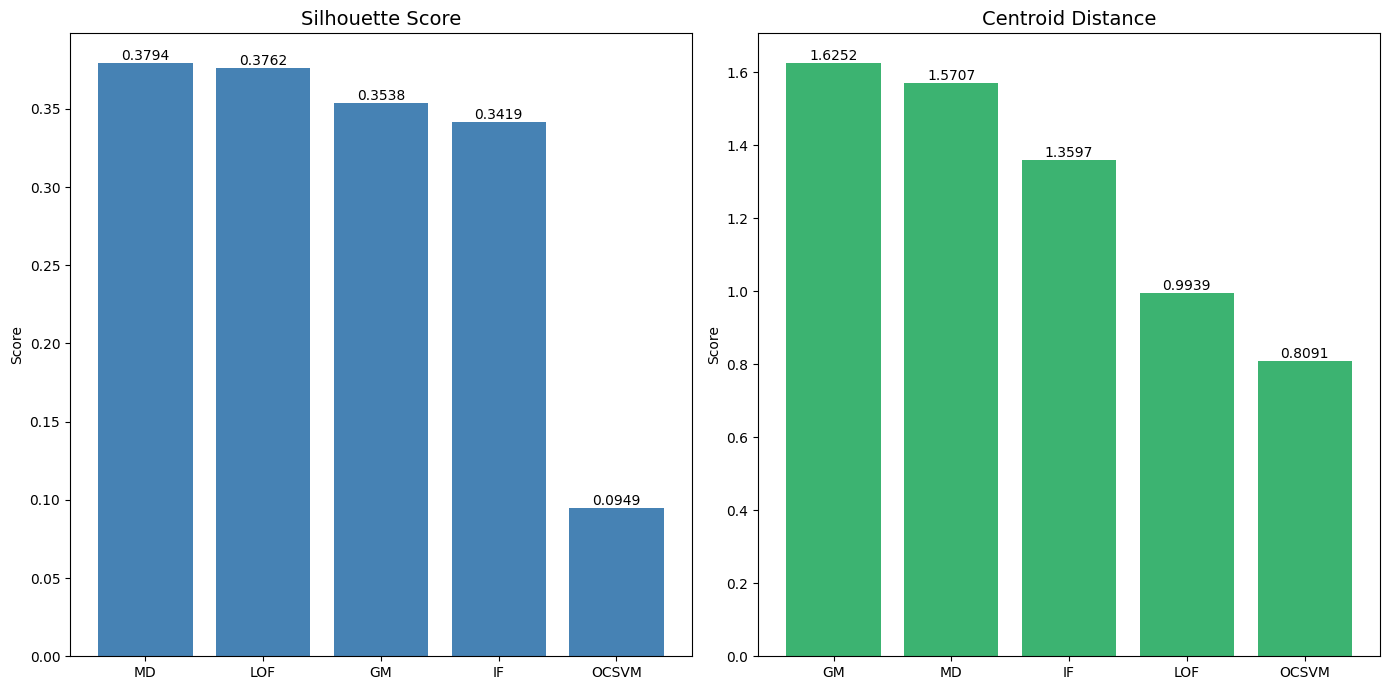

In [85]:
features = df_scaled.columns
results = []

for name, df in models.items():
    labels = df['anomaly'].values
    
    normal_pts = df[df['anomaly'] == 1][features]
    anomaly_pts = df[df['anomaly'] == -1][features]
    
    dist_val = 0
    if not anomaly_pts.empty and not normal_pts.empty:
        c_normal = normal_pts.mean(axis=0).values.reshape(1, -1)
        c_anomaly = anomaly_pts.mean(axis=0).values.reshape(1, -1)
        dist_val = pairwise_distances(c_normal, c_anomaly, metric='euclidean')[0][0]

    results.append({
        'Model': name,
        'Silhouette': silhouette_score(df[features], labels),
        'Centroid Distance': dist_val
    })

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
metrics = [
    ('Silhouette', 'Silhouette Score', 'steelblue'),
    ('Centroid Distance', 'Centroid Distance', 'mediumseagreen')
]

for i, (key, title, color) in enumerate(metrics):
    sorted_res = sorted(results, key=lambda x: x[key], reverse=True)
    names = [r['Model'] for r in sorted_res]
    vals = [r[key] for r in sorted_res]
    
    bars = axes[i].bar(names, vals, color=color)
    axes[i].set_title(title, fontsize=14)
    axes[i].set_ylabel('Score')
    
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center',
            va='bottom'
        )

plt.tight_layout()
plt.show()

* As observed from the graph, MD is the most balanced model here. It holds the highest Silhouette Score and the second place in Centroid Distance, showing that it creates the cleanest separation between classes.

* GMM excels at pushing anomalies far away from the normal data center, making it the highest Centroid Distance. While its Silhouette score is slightly lower than Mahalanobis, it is still a very strong method for this dataset.

* LOF performs excellently on the Silhouette Score, ranking second. This suggests it is very good at identifying distinct groups of anomalies. However, it has a significantly lower Centroid Distance because the anomalies are scattered throughout the periphery of the entire dataset, as seen in the graph above.

* Despite its name, IF only places in the bottom half of all the metrics, proving it can identify outliers but lacks the precision to truly isolate them as effectively as its peers.

* Ranking last across the metrics, OCSVM suffers from a total lack of specificity. Its near 1:1 classification ratio shows that it isn't identifying outliers so much as it is splitting the dataset in half. 

# 7. Conclusion

In this project I successfully implemented five anomaly detection models on the Yeast dataset. Among them, the Mahalanobis Distance model performed the best, while the One-Class SVM model showed the weakest performance. Future work will explore additional approaches, such as deep learning methods and other advanced techniques, and hyperparameter tuning for existing methods to further improve anomaly detection efficiency.
